# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Imports

In [ ]:
!pip install -q tensorboardX

## Utils

#### Saidul drive

In [ ]:
dataset_dir = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder/datasets'
data_dir = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder/data'
DH_dir = 'Dense_Haze'
ITS_dir = 'ITS'
SOTS_dir = 'SOTS'
NH_dir = 'NH_Haze'
base = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import random
import sys
import time
import math
import torch
import torch.utils.data as data
import torchvision.transforms as tfs
from torchvision.transforms import functional as FF
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import h5py
import glob
from tensorboardX import SummaryWriter

from torch.backends import cudnn
from torch import optim
import torch, warnings
from torch import nn

import torch.nn.functional as F
from torch.nn import init
import functools

from torch.autograd import Variable
from torchvision import models

py_file_location = os.path.join(base, 'DCNv2_pytorch')
print(py_file_location)
sys.path.append(os.path.abspath(py_file_location))

from dcn import DeformableConv2d as DCN
from torch.nn.modules import conv
from torch.nn.modules.utils import _pair
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### Metrics

In [ ]:
def create_gaussian_kernel(window_size, sigma):

    center = window_size // 2
    kernel_values = [
        math.exp(-(x - center) ** 2 / (2 * sigma ** 2))
        for x in range(window_size)
    ]

    kernel = torch.Tensor(kernel_values)
    kernel = kernel / kernel.sum()

    return kernel

def create_gaussian_window(window_size, channel, sigma=1.5):

    kernel_1d = create_gaussian_kernel(window_size,sigma).unsqueeze(1)
    kernel_2d = kernel_1d.mm(kernel_1d.t()).float().unsqueeze(0).unsqueeze(0)

    kernel = Variable(kernel_2d.expand(channel, 1, window_size, window_size).contiguous())

    return kernel

def _ssim(image1, image2, kernel, window_size, channel, size_average=True):
    def calculate_mean(image, kernel, window_size, channel):
        return F.conv2d(image, kernel, padding=window_size // 2, groups=channel)

    def calculate_variance(image, window, window_size, channel):
        image_squared = image * image  # Square for variance computation
        return F.conv2d(image_squared, window, padding=window_size // 2, groups=channel)

    def calculate_covariance(image1, image2, window, window_size, channel):
        return F.conv2d(image1 * image2, window, padding=window_size // 2, groups=channel)

    mean1 = calculate_mean(image1, kernel, window_size, channel)
    mean2 = calculate_mean(image2, kernel, window_size, channel)

    variance1 = calculate_variance(image1, kernel, window_size, channel) - mean1.pow(2)
    variance2 = calculate_variance(image2, kernel, window_size, channel) - mean2.pow(2)

    covariance = calculate_covariance(image1, image2, kernel, window_size, channel) - mean1 * mean2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mean1 * mean2 + C1) * (2 * covariance + C2)) / \
               ((mean1.pow(2) + mean2.pow(2) + C1) * (variance1 + variance2 + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(image1, image2, window_size=11, size_average=True):
    image1 = torch.clamp(image1, min=0, max=1)
    image2 = torch.clamp(image2, min=0, max=1)

    (_, channels, _, _) = image1.size()

    kernel = create_gaussian_window(window_size, channels)

    if image1.is_cuda:
        kernel = kernel.cuda(image1.get_device())

    kernel = kernel.type_as(image1)

    return _ssim(image1, image2, kernel, window_size, channels, size_average)

def psnr(pred, gt):
    pred = np.clip(pred.detach().cpu().numpy(), 0, 1).astype(np.float32)
    gt = np.clip(gt.detach().cpu().numpy(), 0, 1).astype(np.float32)

    mse = np.mean((pred - gt) ** 2)

    if mse == 0:
        return 100

    max_pixel_value = 1.0
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))

    return psnr

## Load Dataset

```
Dense-Haze is the NTIRE2019 challenge dataset in the single image dehazing task, which consists of dense and
homogeneous hazy scenes. The hazy scenes have been recorded by introducing real haze generated by
professional haze machines. It consists of 45 training images, 5 validation images and 5 test images. As the
ground-truth test images are not public, we use validation images as test set in our work. NH-HAZE is
the NTIRE2020 challenge dataset in the single image dehazing task, which also consists of 45 training
images, 5 validation images and 5 test images. As both the ground-truth of validation images and test images
are not public, we divide training images into training set and test set which consist of 40 images and 5
images respectively. Different from other datasets, the hazy on NH-HAZE is nonhomogeneous. The sizes both in
Dense-Haze and Dense-Haze are 1,600×1,200.
```

### Dense-haze dataset

In [ ]:
batch_size = 16
size = 224

In [ ]:
class DHAZE_Dataset(data.Dataset):
    def __init__(self, path, train, size, format='.png'):
        super(DHAZE_Dataset, self).__init__()
        self.size = size
        self.train = train
        self.hazy_path = path + '/hazy/'
        self.gt_path = path + '/gt/'
        self.format = format

    def __getitem__(self, index):
        index = index + 1
        # print(f"HAZY PATH: {self.hazy_path}")
        # print(f"GT PATH: {self.gt_path}")
        # print(f"FORMAT: {self.format}\n")
        hazy_filename = self.hazy_path + str(index) + '_hazy' + self.format
        # print(hazy_filename)
        gt_filename = self.gt_path + str(index) + '_GT' + self.format
        # print(gt_filename)

        hazy = Image.open(hazy_filename)
        gt = Image.open(gt_filename)

        gt = tfs.CenterCrop(hazy.size[::-1])(gt)

        if not isinstance(self.size, str):
            i, j, h, w = tfs.RandomCrop.get_params(hazy, output_size=(self.size, self.size))
            hazy = FF.crop(hazy, i, j, h, w)
            gt = FF.crop(gt, i, j, h, w)

        hazy, gt = self.augment_data(hazy.convert("RGB"), gt.convert("RGB"))

        return hazy, gt

    def augment_data(self, hazy, gt):

        if self.train:
            rand_hor = random.randint(0, 1)
            rand_rot = random.randint(0, 3)
            hazy = tfs.RandomHorizontalFlip(rand_hor)(hazy)
            gt = tfs.RandomHorizontalFlip(rand_hor)(gt)
            if rand_rot:
                hazy = FF.rotate(hazy, 90*rand_rot)
                gt = FF.rotate(gt, 90*rand_rot)

        hazy = tfs.ToTensor()(hazy)
        gt = tfs.ToTensor()(gt)

        return hazy, gt

    def __len__(self):
        train_list = glob.glob(self.hazy_path + '/*')

        return len(train_list)


In [ ]:
DH_train_loader=DataLoader(dataset=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_train'), train=True, size=size), batch_size=batch_size, shuffle=True)
DH_test_loader=DataLoader(dataset=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_test'), train=False, size=size), batch_size=1, shuffle=False)

In [ ]:
len(DH_train_loader.dataset)

In [ ]:
print(len(DH_train_loader))
len(DH_test_loader)

In [ ]:
print(len(DH_train_loader.dataset))

In [ ]:
ds=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_test'), train=False, size=size)

In [ ]:
def plot_sample(dataset, index=0):
    haze, clear = dataset[index]

    haze_img = haze.numpy().transpose((1, 2, 0))
    clear_img = clear.numpy().transpose((1, 2, 0))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.imshow(haze_img)
    ax1.set_title('Hazy Image')

    ax2.imshow(clear_img)
    ax2.set_title('Clear Image')

    plt.tight_layout()
    plt.show()

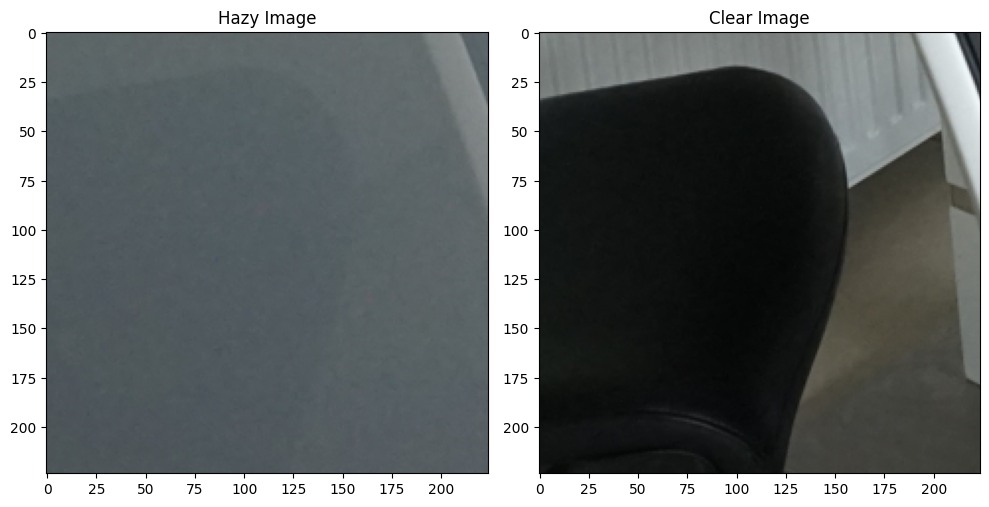

In [ ]:
plot_sample(ds, index=3)

### NH-haze dataset

In [ ]:
class NH_HAZE_Dataset(data.Dataset):
    def __init__(self, path, train, size, format='.png'):
        super(NH_HAZE_Dataset, self).__init__()
        self.size = size
        self.train = train
        self.hazy_path = path + '/hazy/'
        self.gt_path = path + '/gt/'
        self.format = format

    def __getitem__(self, index):
        index = index + 1
        # print(f"HAZY PATH: {self.hazy_path}")
        # print(f"GT PATH: {self.gt_path}")
        # print(f"FORMAT: {self.format}\n")
        hazy_filename = self.hazy_path + str(index) + '_hazy' + self.format
        # print(hazy_filename)
        gt_filename = self.gt_path + str(index) + '_GT' + self.format
        # print(gt_filename)

        hazy = Image.open(hazy_filename)
        gt = Image.open(gt_filename)

        gt = tfs.CenterCrop(hazy.size[::-1])(gt)

        if not isinstance(self.size, str):
            i, j, h, w = tfs.RandomCrop.get_params(hazy, output_size=(self.size, self.size))
            hazy = FF.crop(hazy, i, j, h, w)
            gt = FF.crop(gt, i, j, h, w)

        hazy, gt = self.augment_data(hazy.convert("RGB"), gt.convert("RGB"))

        return hazy, gt

    def augment_data(self, hazy, gt):

        if self.train:
            rand_hor = random.randint(0, 1)
            rand_rot = random.randint(0, 3)
            hazy = tfs.RandomHorizontalFlip(rand_hor)(hazy)
            gt = tfs.RandomHorizontalFlip(rand_hor)(gt)
            if rand_rot:
                hazy = FF.rotate(hazy, 90*rand_rot)
                gt = FF.rotate(gt, 90*rand_rot)

        hazy = tfs.ToTensor()(hazy)
        gt = tfs.ToTensor()(gt)

        return hazy, gt

    def __len__(self):
        train_list = glob.glob(self.hazy_path + '/*')

        return len(train_list)


In [ ]:
NH_train_loader=DataLoader(dataset=NH_HAZE_Dataset(os.path.join(dataset_dir, NH_dir, 'NH_train'), train=True,size=size),batch_size=batch_size,shuffle=True)
NH_test_loader=DataLoader(dataset=NH_HAZE_Dataset(os.path.join(dataset_dir, NH_dir, 'NH_test'),train=False,size=size),batch_size=1,shuffle=False)

In [ ]:
print(len(NH_train_loader))
len(NH_test_loader)

## Model Implementation

### Selective feature contrastive loss

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, vgg_model, beta=0.1, device='cuda'):
        super(ContrastiveLoss, self).__init__()
        self.beta = beta
        self.device = device
        self.feature_extractor = vgg_model
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1]

    def forward(self, anchor, positive, negative):
        reconstruction_loss = F.l1_loss(anchor, positive)

        anchor_features = self.feature_extractor(anchor)
        positive_features = self.feature_extractor(positive)
        negative_features = self.feature_extractor(negative)

        contrastive_loss = 0.0

        for i, (a_f, p_f, n_f) in enumerate(zip(anchor_features, positive_features, negative_features)):
            positive_distance = F.l1_loss(a_f, p_f)
            negative_distance = F.l1_loss(n_f, a_f)
            contrastive_loss += self.weights[i] * (positive_distance / negative_distance)

        total_loss = reconstruction_loss + self.beta * contrastive_loss

        return total_loss



class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg19_model = models.vgg19(pretrained=True)
        self.feature_layers = nn.Sequential(*list(vgg19_model.features.children())[:22]) # Up to 13th layer

        for parameter in self.parameters():
            parameter.requires_grad = False

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.feature_layers):
            x = layer(x)
            if i in [0, 2, 4, 8, 12]: # 1st, 3rd, 5th, 9th, and 13th layers
                features.append(x)

        return features

In [ ]:
def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    A_isqrt = Z / torch.sqrt(normA)
    return A_isqrt

In [ ]:
def isqrt_newton_schulz_autograd_batch(A, numIters):
    batchSize,dim,_ = A.shape
    normA=A.view(batchSize, -1).norm(2, 1).view(batchSize, 1, 1)
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z.bmm(Y))
        Y = Y.bmm(T)
        Z = T.bmm(Z)
    A_isqrt = Z / torch.sqrt(normA)

    return A_isqrt

### FAST DECONV

In [ ]:
class FastDeconv(conv._ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,groups=1,bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=64, sampling_stride=3,freeze=False,freeze_iter=100):
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.counter=0
        self.track_running_stats=True
        super(FastDeconv, self).__init__(
            in_channels, out_channels,  _pair(kernel_size), _pair(stride), _pair(padding), _pair(dilation),
            False, _pair(0), groups, bias, padding_mode='zeros')

        if block > in_channels:
            block = in_channels
        else:
            if in_channels%block!=0:
                block=math.gcd(block,in_channels)

        if groups>1:
            block=in_channels//groups

        self.block=block
        self.num_features = kernel_size**2 *block

        if groups==1:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_deconv', torch.eye(self.num_features))
        else:
            self.register_buffer('running_mean', torch.zeros(kernel_size ** 2 * in_channels))
            self.register_buffer('running_deconv', torch.eye(self.num_features).repeat(in_channels // block, 1, 1))

        self.sampling_stride=sampling_stride*stride
        self.counter=0
        self.freeze_iter=freeze_iter
        self.freeze=freeze

    def forward(self, x):
        N, C, H, W = x.shape
        B = self.block
        frozen=self.freeze and (self.counter>self.freeze_iter)
        if self.training and self.track_running_stats:
            self.counter+=1
            self.counter %= (self.freeze_iter * 10)

        if self.training and (not frozen):

            if self.kernel_size[0]>1:
                X = torch.nn.functional.unfold(x, self.kernel_size,self.dilation,self.padding,self.sampling_stride).transpose(1, 2).contiguous()
            else:
                X = x.permute(0, 2, 3, 1).contiguous().view(-1, C)[::self.sampling_stride**2,:]

            if self.groups==1:
                X = X.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1, self.num_features)
            else:
                X=X.view(-1,X.shape[-1])

            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)

            if self.groups==1:
                Id = torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
                deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            else:
                X = X.view(-1, self.groups, self.num_features).transpose(0, 1)
                Id = torch.eye(self.num_features, dtype=X.dtype, device=X.device).expand(self.groups, self.num_features, self.num_features)
                Cov = torch.baddbmm(self.eps, Id, 1. / X.shape[1], X.transpose(1, 2), X)

                deconv = isqrt_newton_schulz_autograd_batch(Cov, self.n_iter)

            if self.track_running_stats:
                self.running_mean.mul_(1 - self.momentum)
                self.running_mean.add_(X_mean.detach() * self.momentum)
                self.running_deconv.mul_(1 - self.momentum)
                self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        if self.groups==1:
            w = self.weight.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1,self.num_features) @ deconv
            b = self.bias - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
            w = w.view(-1, C // B, self.num_features).transpose(1, 2).contiguous()
        else:
            w = self.weight.view(C//B, -1,self.num_features)@deconv
            b = self.bias - (w @ (X_mean.view( -1,self.num_features,1))).view(self.bias.shape)

        w = w.view(self.weight.shape)
        x= F.conv2d(x, w, b, self.stride, self.padding, self.dilation, self.groups)

        return x

### AECR-NET

### FFA net [Model](https://github.com/zhilin007/FFA-Net/blob/master/net/models/FFA.py)

> OUR IMPLEMENTATION

In [ ]:
##############################THIS PART FROM FFA NET#######################

### FFA NET Model Code
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)

class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1=conv(dim, dim, kernel_size, bias=True)
        self.act1=nn.ReLU(inplace=True)
        self.conv2=conv(dim,dim,kernel_size,bias=True)
        self.calayer=CALayer(dim)
        self.palayer=PALayer(dim)
    def forward(self, x):
        res=self.act1(self.conv1(x))
        res=res+x
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x
        return res

###########################UPTO THIS POINT FROM FFA NET######################

#################  ######################
class DCNBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DCNBlock, self).__init__()
        self.dcn = DCN(input_dim, output_dim, kernel_size=(3,3), stride=1, padding=1).cuda()
    def forward(self, x):
        return self.dcn(x)
################  ######################

class MixupBlock(nn.Module):
    def __init__(self, mixup_factor=1):
        super(MixupBlock, self).__init__()
        tensor = torch.nn.Parameter(torch.FloatTensor([mixup_factor]), requires_grad=True)
        self.theta = tensor
        self.sigmoid = nn.Sigmoid()

    def forward(self, down_feat, up_feat):
        mixup_value = self.sigmoid(self.theta)
        result = down_feat * mixup_value.expand_as(down_feat) +  up_feat * (1 - mixup_value.expand_as(up_feat))
        #result = mixup_value * mixup_value.expand_as(down_feat) + (1 - mixup_value.expand_as(up_feat)) * up_feat

        return result

################## ####################

class AECR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, num_filters=64):
        super(AECR_Net, self).__init__()
        self.num_filters = num_filters
        self.input_dim = input_dim
        self.output_dim = output_dim


        # self.downsample1 = nn.Sequential(
        #     nn.ReflectionPad2d(2),
        #     nn.Conv2d(input_dim, num_filters, kernel_size=5, stride=1,padding=0),
        #     nn.ReLU(True)
        # )


        self.downsample1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_dim, num_filters, kernel_size=7, stride=1,padding=0),
            nn.ReLU(True)
        )
        self.downsample2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.downsample3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )


        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )

        # self.upsample3 = nn.Sequential(
        #     nn.ReflectionPad2d(2),
        #     nn.Conv2d(num_filters, output_dim, kernel_size=5, stride=1, padding=0),
        #     nn.Sigmoid()
        # )

        self.upsample3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(num_filters, output_dim, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )


        self.block = Block(default_conv, num_filters * 4, 3)

        self.dcn_block = DCNBlock(256, 256)

        self.channel_deconv = FastDeconv(3, 3, kernel_size=3, stride=1, padding=1)

        self.mixup1 = MixupBlock(mixup_factor=1)
        self.mixup2 = MixupBlock(mixup_factor=1)


    def forward(self, x):

        x_channel_deconv = self.channel_deconv(x)
        #print(x_channel_deconv.shape)
        downsample1_out = self.downsample1(x_channel_deconv)
        #print(downsample1_out.shape)
        downsample2_out = self.downsample2(downsample1_out)
        #print(downsample2_out.shape)
        downsample3_out = self.downsample3(downsample2_out)
        #print(downsample3_out.shape)

        ffa1 = self.block(downsample3_out)
        ffa2 = self.block(ffa1)
        ffa3 = self.block(ffa2)
        ffa4 = self.block(ffa3)
        ffa5 = self.block(ffa4)
        ffa6 = self.block(ffa5)

        #print(ffa6.shape)

        dcn1_out = self.dcn_block(ffa6)
        #print(dcn1_out.shape)

        dcn2_out = self.dcn_block(dcn1_out)
        #print(dcn2_out.shape)

        mix1_out = self.mixup1(downsample3_out, dcn2_out)
        #print(mix1_out.shape)
        upsample1_out = self.upsample1(mix1_out)
        #print(upsample1_out.shape)
        mixup2_out = self.mixup2(downsample2_out, upsample1_out)
        upsample2_out = self.upsample2(mixup2_out)
        #print(upsample2_out.shape)
        out = self.upsample3(upsample2_out)
        #print(out.shape)
        return out

### POTENTIAL ISSUES : [ISSUES](https://github.com/GlassyWu/AECR-Net/issues)

### Training Loop

In [ ]:
config = {
    'epochs': 100,
    'eval_step': 1000,
    'lr': 0.0002,
    'model_dir': 'trained_models',
    'model_name': 'AECR_Net',
    'bs': 16,
    'size': 224,
}

print(config)
print('model_dir:', config['model_dir'])

In [ ]:
print(config)
print('model_dir:', config['model_dir'])

In [ ]:
data_loaders = {
	'NH_train': NH_train_loader,
	'NH_test': NH_test_loader,
	'DH_train': DH_train_loader,
	'DH_test': DH_test_loader,
}

In [ ]:
start_time = time.time()
model_name = config['model_name']
steps = config['eval_step'] * config['epochs']
epochs = config['epochs']
init_lr = config['lr']

# DH Haze

In [ ]:
def test(model,test_loader):
	model.eval()
	torch.cuda.empty_cache()
	ssims = []
	psnrs = []

	for i, (inputs, targets) in enumerate(test_loader):
		inputs = inputs.to(device);targets = targets.to(device)
		with torch.no_grad():
			pred = model(inputs)

		ssim1 = ssim(pred, targets).item()
		psnr1 = psnr(pred, targets)
		ssims.append(ssim1)
		psnrs.append(psnr1)

	return np.mean(ssims), np.mean(psnrs)

In [ ]:
def lr_schedule_cosdecay(t, steps , init_lr=init_lr):
	lr = 0.5 * (1 + math.cos(t * math.pi / steps)) * init_lr
	return lr

In [ ]:
def set_seed_torch(seed=2000):
	os.environ['PYTHONHASHSEED'] = str(seed)
	np.random.seed(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.backends.cudnn.deterministic = True

In [ ]:
config = {
    'epochs': 100,
    'eval_step': 5,
    'lr': 0.0002,
    'model_dir': 'trained_models_dh',
    'model_name': 'DH_Net',
    'bs': 16,
    'size': 224,
}

print(config)
print('model_dir:', config['model_dir'])

In [ ]:
start_time = time.time()
model_name = config['model_name']
steps = config['eval_step'] * config['epochs']
epochs = config['epochs']
init_lr = config['lr']

In [ ]:
set_seed_torch(2000)

In [ ]:
model = AECR_Net(3, 3)
model = model.to(device)

In [ ]:
vgg_model = VGGFeatureExtractor()

In [ ]:
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total_params: ==> {}".format(pytorch_total_params))

In [ ]:
loss_fn = []
loss_fn.append(nn.L1Loss().to(device))
loss_fn.append(ContrastiveLoss(vgg_model).to(device))

In [ ]:
optimizer = optim.Adam(params=filter(lambda x: x.requires_grad, model.parameters()), lr=init_lr, betas = (0.9, 0.999), eps=1e-08)
optimizer.zero_grad()

In [ ]:
resume_dh=True

In [ ]:
if resume_dh:
  last_data_path = './data/trained_models_dh/trained_model.best'
  saved_data = torch.load(last_data_path)

In [ ]:
saved_epoch = saved_data['epoch']
saved_step = saved_data['step']
saved_max_psnr = saved_data['max_psnr']
saved_max_ssim = saved_data['max_ssim']
saved_ssims = saved_data['ssims']
saved_psnrs = saved_data['psnrs']
saved_losses = saved_data['losses']
saved_model = saved_data['model']
saved_optimizer = saved_data['optimizer']

In [ ]:
data_loaders = {
	'NH_train': NH_train_loader,
	'NH_test': NH_test_loader,
	'DH_train': DH_train_loader,
	'DH_test': DH_test_loader,
}

In [ ]:
train_loader = data_loaders['DH_train']
test_loader = data_loaders['DH_test']

In [ ]:
print(saved_epoch)
print(saved_step)
print(saved_max_psnr)
print(saved_max_ssim)
print(saved_ssims)
print(saved_psnrs)
print(saved_losses)

In [ ]:
def train_dh(model, train_loader, test_loader, optimizer, loss_fn):
	losses = []
	start_step = 0
	max_ssim = 0
	max_psnr = 0
	ssims = []
	psnrs = []


	if resume_dh:
		losses = saved_losses
		start_step = saved_step
		max_ssim = saved_max_ssim
		max_psnr = saved_max_psnr
		ssims = saved_ssims
		psnrs = saved_psnrs
		optimizer.load_state_dict(saved_optimizer)
		model.load_state_dict(saved_model)
		print(f'model loaded from {last_data_path}')


	for step in range(start_step+1, steps+1):

		model.train()
		lr = init_lr
		lr = lr_schedule_cosdecay(step, steps,init_lr)
		for param_group in optimizer.param_groups:
			param_group["lr"] = lr

		x, y = next(iter(train_loader))
		x = x.to(device)
		y = y.to(device)

		out = model(x)

		# print(f"Output : {out.shape}" )
		# print(f"Target: {y.shape}")

		l1_loss, contrastive_loss = 0.0, 0.0

		l1_loss = loss_fn[0](out, y)
		contrastive_loss = loss_fn[1](out, y, x)
		loss = l1_loss + contrastive_loss

		loss.backward()

		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())

		print(f'loss: {loss.item():.5f}, L1_loss: {l1_loss:.5f}, Contrastive_loss: {contrastive_loss:.5f}, | step :{step}/{steps}|lr :{lr :.7f} |time_used :{(time.time() - start_time) / 60 :.1f}',end='', flush=True)

		with SummaryWriter(logdir='./data/dh-logs', comment='./data/dh-logs') as writer:
					writer.add_scalar('runs-loss', loss, step)
					writer.add_scalar('runs-loss_l1', l1_loss, step)
					writer.add_scalar('runs-contrastive_loss', contrastive_loss, step)

		if step % config['eval_step'] == 0:
		#if step%1 == 0:
			epoch = step // config['eval_step']

			save_model_dir = f'./data/trained_models_dh/{epoch}.ok'
			best_model_dir = './data/trained_models_dh/trained_model.best'

			with torch.no_grad():
				ssim_eval, psnr_eval = test(model, test_loader)

			log = f'\nstep :{step} | epoch: {epoch} | ssim:{ssim_eval:.4f}| psnr:{psnr_eval:.4f}'

			model_name = config['model_name']

			print(log)
			with open(f'./data/dh-logs/{model_name}.txt', 'a') as f:
				f.write(log + '\n')

			ssims.append(ssim_eval)
			psnrs.append(psnr_eval)

			if psnr_eval > max_psnr:
				max_ssim = max(max_ssim, ssim_eval)
				max_psnr = max(max_psnr, psnr_eval)
				print(f'\n model saved at step :{step}| epoch: {epoch} | max_psnr:{max_psnr:.4f}| max_ssim:{max_ssim:.4f}')
				torch.save({
					'epoch': epoch,
					'step': step,
					'max_psnr': max_psnr,
					'max_ssim': max_ssim,
					'ssims': ssims,
					'psnrs': psnrs,
					'losses': losses,
					'model': model.state_dict(),
					'optimizer': optimizer.state_dict()
				}, best_model_dir)



			torch.save({
				'epoch': epoch,
				'step': step,
				'max_psnr': max_psnr,
				'max_ssim': max_ssim,
				'ssims': ssims,
				'psnrs': psnrs,
				'losses': losses,
				'model': model.state_dict(),
				'optimizer': optimizer.state_dict()
			}, save_model_dir)

	#return

	np.save(f'./data/dh_numpy_files/{model_name}_{steps}_losses.npy', losses)
	np.save(f'./data/dh_numpy_files/{model_name}_{steps}_ssims.npy', ssims)
	np.save(f'./data/dh_numpy_files/{model_name}_{steps}_psnrs.npy', psnrs)

In [ ]:
train_dh(model, train_loader, test_loader, optimizer, loss_fn)

loss: 1.47994, L1_loss: 0.41406, Contrastive_loss: 1.06588, | step :1/500|lr :0.0002000 |time_used :1.3loss: 1.20212, L1_loss: 0.34364, Contrastive_loss: 0.85848, | step :2/500|lr :0.0002000 |time_used :2.4loss: 0.94000, L1_loss: 0.30954, Contrastive_loss: 0.63046, | step :3/500|lr :0.0002000 |time_used :2.8loss: 1.03840, L1_loss: 0.37685, Contrastive_loss: 0.66155, | step :4/500|lr :0.0002000 |time_used :3.0loss: 1.00356, L1_loss: 0.38465, Contrastive_loss: 0.61892, | step :5/500|lr :0.0002000 |time_used :3.1
step :5 | epoch: 1 | ssim:0.0904| psnr:10.0804

 model saved at step :5| epoch: 1 | max_psnr:10.0804| max_ssim:0.0904
loss: 0.97749, L1_loss: 0.39446, Contrastive_loss: 0.58303, | step :6/500|lr :0.0001999 |time_used :3.3loss: 0.87544, L1_loss: 0.35786, Contrastive_loss: 0.51757, | step :7/500|lr :0.0001999 |time_used :3.3loss: 0.80893, L1_loss: 0.32153, Contrastive_loss: 0.48740, | step :8/500|lr :0.0001999 |time_used :3.4loss: 0.67699, L1_loss: 0.25304, Contrastive_loss: 0.4239

# NH Haze

In [ ]:
config = {
    'epochs': 100,
    'eval_step': 5,
    'lr': 0.0002,
    'model_dir': 'trained_models_nh',
    'model_name': 'NH_Net',
    'bs': 16,
    'size': 224,
}

print(config)
print('model_dir:', config['model_dir'])

In [ ]:
start_time = time.time()
model_name = config['model_name']
steps = config['eval_step'] * config['epochs']
epochs = config['epochs']
init_lr = config['lr']

In [ ]:
set_seed_torch(2000)

In [ ]:
model = AECR_Net(3, 3)
model = model.to(device)

In [ ]:
vgg_model = VGGFeatureExtractor()

In [ ]:
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total_params: ==> {}".format(pytorch_total_params))

In [ ]:
loss_fn = []
loss_fn.append(nn.L1Loss().to(device))
loss_fn.append(ContrastiveLoss(vgg_model).to(device))

In [ ]:
optimizer = optim.Adam(params=filter(lambda x: x.requires_grad, model.parameters()), lr=init_lr, betas = (0.9, 0.999), eps=1e-08)
optimizer.zero_grad()

In [ ]:
resume_nh=True

In [ ]:
if resume_nh:
  last_data_path = './data/trained_models_nh/trained_model.best'
  saved_data = torch.load(last_data_path)

In [ ]:
saved_epoch = saved_data['epoch']
saved_step = saved_data['step']
saved_max_psnr = saved_data['max_psnr']
saved_max_ssim = saved_data['max_ssim']
saved_ssims = saved_data['ssims']
saved_psnrs = saved_data['psnrs']
saved_losses = saved_data['losses']
saved_model = saved_data['model']
saved_optimizer = saved_data['optimizer']

In [ ]:
data_loaders = {
	'NH_train': NH_train_loader,
	'NH_test': NH_test_loader,
	'DH_train': DH_train_loader,
	'DH_test': DH_test_loader,
}

In [ ]:
train_loader = data_loaders['NH_train']
test_loader = data_loaders['NH_test']

In [ ]:
print(saved_epoch)
print(saved_step)
print(saved_max_psnr)
print(saved_max_ssim)
print(saved_ssims)
print(saved_psnrs)
print(saved_losses)

In [ ]:
def train_nh(model, train_loader, test_loader, optimizer, loss_fn):
	losses = []
	start_step = 0
	max_ssim = 0
	max_psnr = 0
	ssims = []
	psnrs = []


	if resume_nh:
		losses = saved_losses
		start_step = saved_step
		max_ssim = saved_max_ssim
		max_psnr = saved_max_psnr
		ssims = saved_ssims
		psnrs = saved_psnrs
		optimizer.load_state_dict(saved_optimizer)
		model.load_state_dict(saved_model)
		print(f'model loaded from {last_data_path}')


	for step in range(start_step+1, steps+1):

		model.train()
		lr = init_lr
		lr = lr_schedule_cosdecay(step, steps,init_lr)
		for param_group in optimizer.param_groups:
			param_group["lr"] = lr

		x, y = next(iter(train_loader))
		x = x.to(device)
		y = y.to(device)

		out = model(x)

		# print(f"Output : {out.shape}" )
		# print(f"Target: {y.shape}")

		l1_loss, contrastive_loss = 0.0, 0.0

		l1_loss = loss_fn[0](out, y)
		contrastive_loss = loss_fn[1](out, y, x)
		loss = l1_loss + contrastive_loss

		loss.backward()

		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())

		print(f'loss: {loss.item():.5f}, L1_loss: {l1_loss:.5f}, Contrastive_loss: {contrastive_loss:.5f}, | step :{step}/{steps}|lr :{lr :.7f} |time_used :{(time.time() - start_time) / 60 :.1f}',end='', flush=True)

		with SummaryWriter(logdir='./data/nh-logs', comment='./data/nh-logs') as writer:
					writer.add_scalar('runs-loss', loss, step)
					writer.add_scalar('runs-loss_l1', l1_loss, step)
					writer.add_scalar('runs-contrastive_loss', contrastive_loss, step)

		if step % config['eval_step'] == 0:
		#if step%1 == 0:
			epoch = step // config['eval_step']

			save_model_dir = f'./data/trained_models_nh/{epoch}.ok'
			best_model_dir = './data/trained_models_nh/trained_model.best'

			with torch.no_grad():
				ssim_eval, psnr_eval = test(model, test_loader)

			log = f'\nstep :{step} | epoch: {epoch} | ssim:{ssim_eval:.4f}| psnr:{psnr_eval:.4f}'

			model_name = config['model_name']

			print(log)
			with open(f'./data/nh-logs/{model_name}.txt', 'a') as f:
				f.write(log + '\n')

			ssims.append(ssim_eval)
			psnrs.append(psnr_eval)

			if psnr_eval > max_psnr:
				max_ssim = max(max_ssim, ssim_eval)
				max_psnr = max(max_psnr, psnr_eval)
				print(f'\n model saved at step :{step}| epoch: {epoch} | max_psnr:{max_psnr:.4f}| max_ssim:{max_ssim:.4f}')
				torch.save({
					'epoch': epoch,
					'step': step,
					'max_psnr': max_psnr,
					'max_ssim': max_ssim,
					'ssims': ssims,
					'psnrs': psnrs,
					'losses': losses,
					'model': model.state_dict(),
					'optimizer': optimizer.state_dict()
				}, best_model_dir)



			torch.save({
				'epoch': epoch,
				'step': step,
				'max_psnr': max_psnr,
				'max_ssim': max_ssim,
				'ssims': ssims,
				'psnrs': psnrs,
				'losses': losses,
				'model': model.state_dict(),
				'optimizer': optimizer.state_dict()
			}, save_model_dir)

	#return

	np.save(f'./data/nh_numpy_files/{model_name}_{steps}_losses.npy', losses)
	np.save(f'./data/nh_numpy_files/{model_name}_{steps}_ssims.npy', ssims)
	np.save(f'./data/nh_numpy_files/{model_name}_{steps}_psnrs.npy', psnrs)

In [ ]:
train_nh(model, train_loader, test_loader, optimizer, loss_fn)

loss: 0.98802, L1_loss: 0.32703, Contrastive_loss: 0.66098, | step :1/500|lr :0.0002000 |time_used :0.4loss: 1.09005, L1_loss: 0.35513, Contrastive_loss: 0.73492, | step :2/500|lr :0.0002000 |time_used :0.5loss: 0.99532, L1_loss: 0.31827, Contrastive_loss: 0.67705, | step :3/500|lr :0.0002000 |time_used :0.6loss: 1.04984, L1_loss: 0.37056, Contrastive_loss: 0.67927, | step :4/500|lr :0.0002000 |time_used :0.6loss: 0.89468, L1_loss: 0.32123, Contrastive_loss: 0.57346, | step :5/500|lr :0.0002000 |time_used :0.6
step :5 | epoch: 1 | ssim:0.1438| psnr:12.8865

 model saved at step :5| epoch: 1 | max_psnr:12.8865| max_ssim:0.1438
loss: 0.89157, L1_loss: 0.33472, Contrastive_loss: 0.55685, | step :6/500|lr :0.0001999 |time_used :0.7loss: 0.69605, L1_loss: 0.25950, Contrastive_loss: 0.43655, | step :7/500|lr :0.0001999 |time_used :0.7loss: 0.99999, L1_loss: 0.41907, Contrastive_loss: 0.58092, | step :8/500|lr :0.0001999 |time_used :0.8loss: 0.87753, L1_loss: 0.35655, Contrastive_loss: 0.5209